In [1]:
%load_ext autoreload
%autoreload 2

import src.ksd.models as models
from src.ksd.find_modes import find_modes, pairwise_directions, run_bfgs
from src.ksd.langevin import RandomWalkMH, RandomWalkBarker
import src.ksd.langevin as mcmc
from src.ksd.ksd import KSD
from src.ksd.kernel import IMQ, RBF
from src.ksd.bootstrap import Bootstrap
from src.ksd.find_modes import find_modes, pairwise_directions
from tqdm.notebook import tqdm, trange

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns

import src.kgof.density as density
import src.kgof.data as data

MCMCKernel = RandomWalkMH # RandomWalkBarker

In [2]:
tf.random.set_seed(1)

In [3]:
def generate_target_proposal(dim):
    ## single gaussians
    k = 1
    delta = 2.
    
    mean1 = tf.eye(dim)[:, 0] * delta
    mean2 = tf.zeros(dim)

    target = tfd.MultivariateNormalDiag(mean1)
    proposal_off = tfd.MultivariateNormalDiag(mean2)
    
    return target, proposal_off

2022-11-14 18:25:01.875918: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-14 18:25:01.875955: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: nvidia4
2022-11-14 18:25:01.875961: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: nvidia4
2022-11-14 18:25:01.876071: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.27.4
2022-11-14 18:25:01.876094: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.27.4
2022-11-14 18:25:01.876099: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.27.4
2022-11-14 18:25:01.877018: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in pe

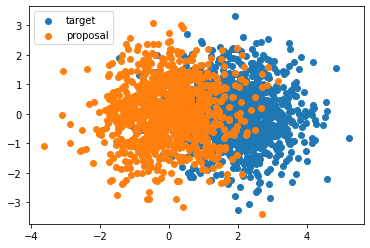

In [4]:
target, proposal = generate_target_proposal(2)
target_x = target.sample(1000)
proposal_x = proposal.sample(1000)

fig, ax = plt.subplots()
ax.scatter(target_x[:, 0], target_x[:, 1], label="target")
ax.scatter(proposal_x[:, 0], proposal_x[:, 1], label="proposal")
ax.legend()
plt.show()

In [5]:
def plot_bandwidth(dims, kernel_class, n):
    
    bandwidths = []
    for d in dims:
        print(f"dim {d}")
        _, proposal_dist = generate_target_proposal(d)
        X = proposal_dist.sample(n)
        
        kernel = kernel_class(med_heuristic=True)
        kernel.bandwidth(X, tf.identity(X))
        bandwidths.append(kernel.sigma_sq)
        
    # plot
    fig, ax = plt.subplots()
    ax.plot(dims, bandwidths, label="empirical")
    ax.plot(dims, 2 * np.array(dims), label="theoretical")
    ax.set_ylabel("Bandwidth")
    ax.set_xlabel("Dim")
    ax.legend()
    plt.show()
    
    return bandwidths

In [6]:
dims = [1, 2, 5, 10, 20, 30, 40, 50, 100]

dim 1
dim 2
dim 5
dim 10
dim 20
dim 30
dim 40
dim 50
dim 100


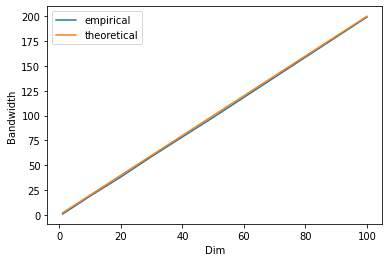

In [7]:
tf.random.set_seed(1)
bandwidths = plot_bandwidth(dims, RBF, n=1000)

In [11]:
def ksd_gaussians(d, bandwidth=None):
    if not bandwidth:
        bandwidth = 2 * d
    
    delta = 2. # TODO change
    mean1 = tf.eye(d)[:, 0] * delta
    mean1_norm_sq = np.sum(mean1**2)
    
    res = (bandwidth / (bandwidth + 4))**(d/2) * mean1_norm_sq
    
#     lmda = bandwidth / 2.
#     term1 = (lmda/(lmda+2))**(d/2) * (d/(lmda + 2) + mean1_norm_sq)
#     term2 = - (lmda/(lmda+2))**(d/2) * d/(lmda + 2)
#     term3 = - (lmda/(lmda+2))**(d/2) * d/(lmda + 2)
#     term4 = (lmda/(lmda+2))**(d/2) * d/(lmda + 2)
#     res = (res, term1, term2, term3, term4)
    
    return res

def h1_var_gaussians(d, bandwidth_order, bandwidth=None):
    if not bandwidth:
        bandwidth = 2 * d
    
    delta = 2. # TODO change
    mean1 = tf.eye(d)[:, 0] * delta
    mean1_norm_sq = np.sum(mean1**2)

    if bandwidth_order > 1.:
        res = 4 * mean1_norm_sq
    elif bandwidth_order == 1.:
        lmda = bandwidth / 2.
        res = 4 * np.exp(-d/lmda - d/(lmda + 3.)) * mean1_norm_sq
        
#         term1 = (lmda/(lmda + 1))**d * ((lmda+1)/(lmda+3))**(d/2) * ( 
#             mean1_norm_sq**2 + (lmda+2)**2/((lmda+1)*(lmda+3)) * mean1_norm_sq 
#         )
#         term2 = (lmda/(lmda + 1))**d * ((lmda+1)/(lmda+2))**d * mean1_norm_sq**2
#         res = (res, term1, term2)
        
    return res

def up_moments_gaussians(d, bandwidth_order, bandwidth=None):
    if not bandwidth:
        bandwidth = 2 * d
    
    lmda = bandwidth / 2.
    if bandwidth_order == 1.:
        res = np.exp(-2*d / lmda) * (d + d**2 / (lmda + 4))
    else:
        res = -1. # placeholder
        
    return res

In [12]:
def compute_ksd(dims, kernel_class, n, bandwidth_order, verbose=False):
    
    ksd_empirical_list = []
    ksd_theoretical_list = []
    h1_var_empirical_list = []
    h1_var_theoretical_list = []
    moment2_empirical_list = []
    moment3_empirical_list = []
    moment4_empirical_list = []
    moment2_theoretical_list = []
    bandwidth_list = []
    for d in dims:
        if verbose:
            print(f"dim: {d}")
        
        target, proposal_dist = generate_target_proposal(d)
        X = proposal_dist.sample(n)
        
        # compute ksd empirically
        kernel = kernel_class(sigma_sq=2.*d**bandwidth_order)

        ksd = KSD(kernel=kernel, log_prob=target.log_prob)
        ksd_val = ksd(X, tf.identity(X))
        ksd_empirical_list.append(ksd_val)
        
        h1_var = ksd.h1_var(X=X, Y=tf.identity(X))
        h1_var_empirical_list.append(h1_var)

        # compute ksd from theoretical formula
        ksd_theoretical_list.append(ksd_gaussians(d, bandwidth=kernel.sigma_sq))
        h1_var_theoretical_list.append(
            h1_var_gaussians(d, bandwidth=kernel.sigma_sq, bandwidth_order=bandwidth_order)
        )

        # store bandwidths
        bandwidth_list.append(kernel.sigma_sq)
        
        # store E[u_p^k] for k = 2, 3, 4
        moment2_empirical_list.append(ksd.u_p_moment(X, tf.identity(X), k=2))
        moment3_empirical_list.append(ksd.u_p_moment(X, tf.identity(X), k=3))
        moment4_empirical_list.append(ksd.u_p_moment(X, tf.identity(X), k=4))
        
        moment2_theoretical_list.append(
            up_moments_gaussians(d, bandwidth=kernel.sigma_sq, bandwidth_order=bandwidth_order)
        )

    res = pd.DataFrame({
        "dim": dims,
        "ksd_empirical": np.array(ksd_empirical_list),
        "ksd_theoretical": np.array(ksd_theoretical_list),
        "h1_var_empirical": np.array(h1_var_empirical_list),
        "h1_var_theoretical": np.array(h1_var_theoretical_list),
        "moment2_empirical": np.array(moment2_empirical_list),
        "moment3_empirical": np.array(moment3_empirical_list),
        "moment4_empirical": np.array(moment4_empirical_list),
        "moment2_theoretical": np.array(moment2_theoretical_list),
        "bandwidth": bandwidth_list,
    })
    
    return res


def repeat_compute_ksd(dims, kernel_class, n, nreps, bandwidth_order, verbose=False):
    res_list = []
    
    for i in range(nreps):
        print(f"[{i+1} / {nreps}]")
        res = compute_ksd(dims, kernel_class, n, bandwidth_order, verbose)
        res["seed"] = i
        res_list.append(res)
        
    res = pd.concat(res_list, axis=0)
    return res


def plot_ksd(res, figsize):
    dims = res["dim"]
    
    figs, axes = plt.subplots(figsize=figsize, nrows=1, ncols=3)
    axes[0].plot(dims, res["ksd_empirical"], marker="o", label="empirical")
    axes[0].plot(dims, res["ksd_theoretical"], marker="x", label="theoretical")
    axes[0].set_ylabel("KSD")
    axes[0].set_xlabel("Dim")
    axes[0].legend()
    
    axes[1].plot(dims, res["h1_var_empirical"], marker="o", label="empirical")
    axes[1].plot(dims, res["h1_var_theoretical"], marker="x", label="theoretical")
    axes[1].set_ylabel("h1_var")
    axes[1].set_xlabel("Dim")
    axes[1].legend()
    
    axes[2].plot(dims, res["ksd_empirical"] / np.sqrt(res["h1_var_empirical"]), marker="o", label="empirical")
    axes[2].plot(dims, res["ksd_theoretical"] / np.sqrt(res["h1_var_theoretical"]), marker="x", label="theoretical")
    axes[2].set_ylabel("KSD / sqrt(h1_var)")
    axes[2].set_xlabel("Dim")
    axes[2].legend()
    
    plt.tight_layout()

#     figs, axes = plt.subplots(figsize=figsize, nrows=1, ncols=3)
#     sns.lineplot(ax=axes[0], data=res, x="dims", y="k")

In [66]:
tf.random.set_seed(2022)
# dims = [1, 2, 5, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500,]
dims = [1, 5, 20, 40, 50, 100, 200, 300]

res = repeat_compute_ksd(dims, RBF, n=4000, nreps=1, bandwidth_order=1., verbose=True)
# res_over = repeat_compute_ksd(dims, RBF, n=4000, nreps=1, bandwidth_order=5., verbose=True)

[1 / 1]
dim: 1
dim: 5
dim: 20
dim: 40
dim: 50
dim: 100
dim: 200
dim: 300


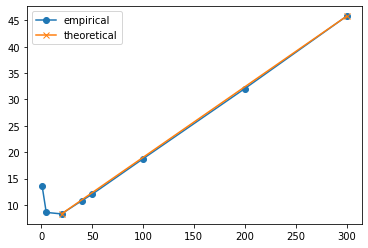

In [52]:
plt.plot(res["dim"], res["moment2_empirical"], marker="o", label="empirical")
# plt.plot(res["dim"], res["moment2_theoretical"], marker="x", label="theoretical")
res_dim = res["dim"].to_numpy()
res_vals = res["moment2_empirical"].to_numpy()
plt.plot([res_dim[2], res_dim[-1]], [res_vals[2], res_vals[-1]], marker="x", label="theoretical")
_ = plt.legend()

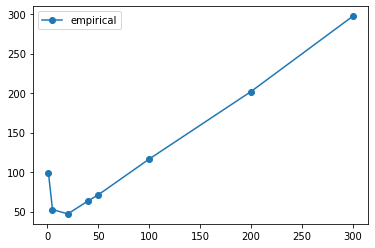

In [30]:
plt.plot(res["dim"], res["moment3_empirical"], marker="o", label="empirical")
# plt.plot(res["dim"], res["moment3_theoretical"], marker="x", label="theoretical")
_ = plt.legend()

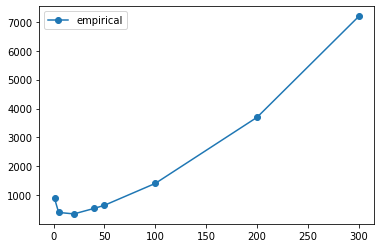

In [50]:
plt.plot(res["dim"], res["moment4_empirical"], marker="o", label="empirical")
_ = plt.legend()

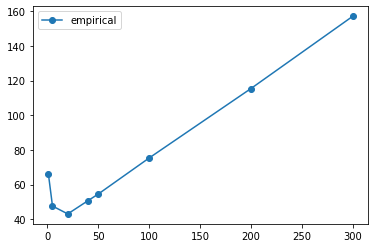

In [43]:
plt.plot(res["dim"], res["moment4_empirical"] / res["moment2_empirical"], marker="o", label="empirical")
_ = plt.legend()

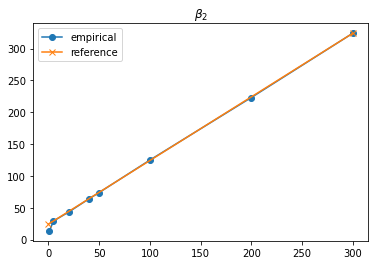

In [71]:
# beta_2 = d + o(d)
plt.plot(res_over["dim"], res_over["moment2_empirical"], marker="o", label="empirical")
# plt.plot(res_over["dim"], res_over["moment2_theoretical"], marker="x", label="theoretical")
final_point_res = res_over["moment2_empirical"].to_numpy()[-1]
plt.plot([0., 300.], [final_point_res-300., final_point_res], marker="x", label="reference")
_ = plt.legend()
_ = plt.title(r"$\beta_2$")

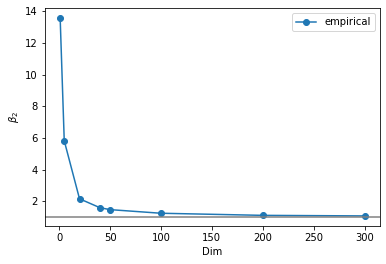

In [76]:
plt.plot(res_over["dim"], res_over["moment2_empirical"] / res_over["dim"], marker="o", label="empirical")
plt.axhline(1., color="grey")
_ = plt.legend()
_ = plt.ylabel(r"$\beta_2$")
_ = plt.xlabel("Dim")

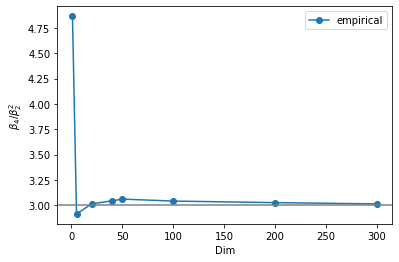

In [77]:
# beta_4 = (3 + o(1)) * beta_2^2
plt.plot(res_over["dim"], res_over["moment4_empirical"] / res_over["moment2_empirical"]**2, marker="o", label="empirical")
plt.axhline(3., color="grey")
_ = plt.legend()
_ = plt.ylabel(r"$\beta_4 / \beta_2^2$")
_ = plt.xlabel("Dim")

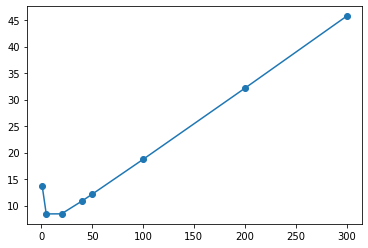

In [162]:
plt.plot(res["dim"], res["zeta_empirical"], marker="o", label="empirical")

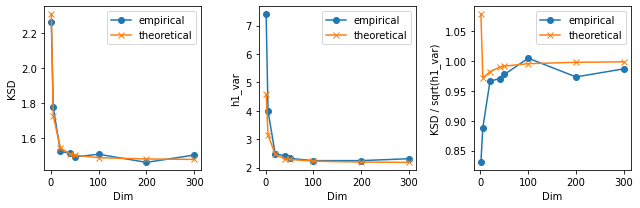

In [67]:
# bandwidth = 2d
plot_ksd(res, figsize=(9, 3))

[1 / 1]


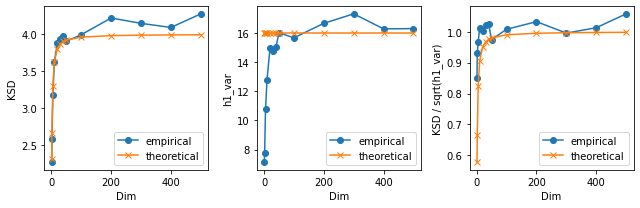

In [91]:
# bandwidth = 2d^r, r > 1
res_over = repeat_compute_ksd(dims, RBF, n=2000, nreps=1, bandwidth_order=2.)
plot_ksd(res_over, figsize=(9, 3))

In [69]:
res["bandwidth"]

0        2.0
1        4.0
2       10.0
3       20.0
4       40.0
5       60.0
6       80.0
7      100.0
8      200.0
9      400.0
10     600.0
11     800.0
12    1000.0
Name: bandwidth, dtype: float64